# Bounce Analysis - Tennis Ball Part 3

## Development Objective of this notebook

We now have the frames in which the ball was located, let's now get the position of the ball in those moments in order to get the exact coordinates

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import cv2
import pickle

In [2]:
# Load the saved coordinates (they are inverted)
with open('ball_coords_no_court_83.pkl', 'rb') as f:
    q = pickle.load(f)
len(q)

447

In [3]:
# Reverse the list
q=q[::-1]

coordenada_x = [q[i][0] if q[i] is not None else np.NaN for i in range(len(q))]
coordenada_y = [q[i][1] if q[i] is not None else np.NaN for i in range(len(q))]

coordenada_x = np.array(coordenada_x)
coordenada_y = np.array(coordenada_y)

# Interpolate the missing values
coordenada_x_filled = pd.Series(coordenada_x).interpolate().values.astype(int)
coordenada_y_filled = pd.Series(coordenada_y).interpolate().values.astype(int)

# Fix the values are borken due to the interpolation
coordenada_x_filled[coordenada_x_filled < 0] = 949
coordenada_y_filled[coordenada_y_filled < 0] = 310

# Import the frames where a bounce occur
with open('peaks_2.pkl', 'rb') as f:
    peaks_dict = pickle.load(f)

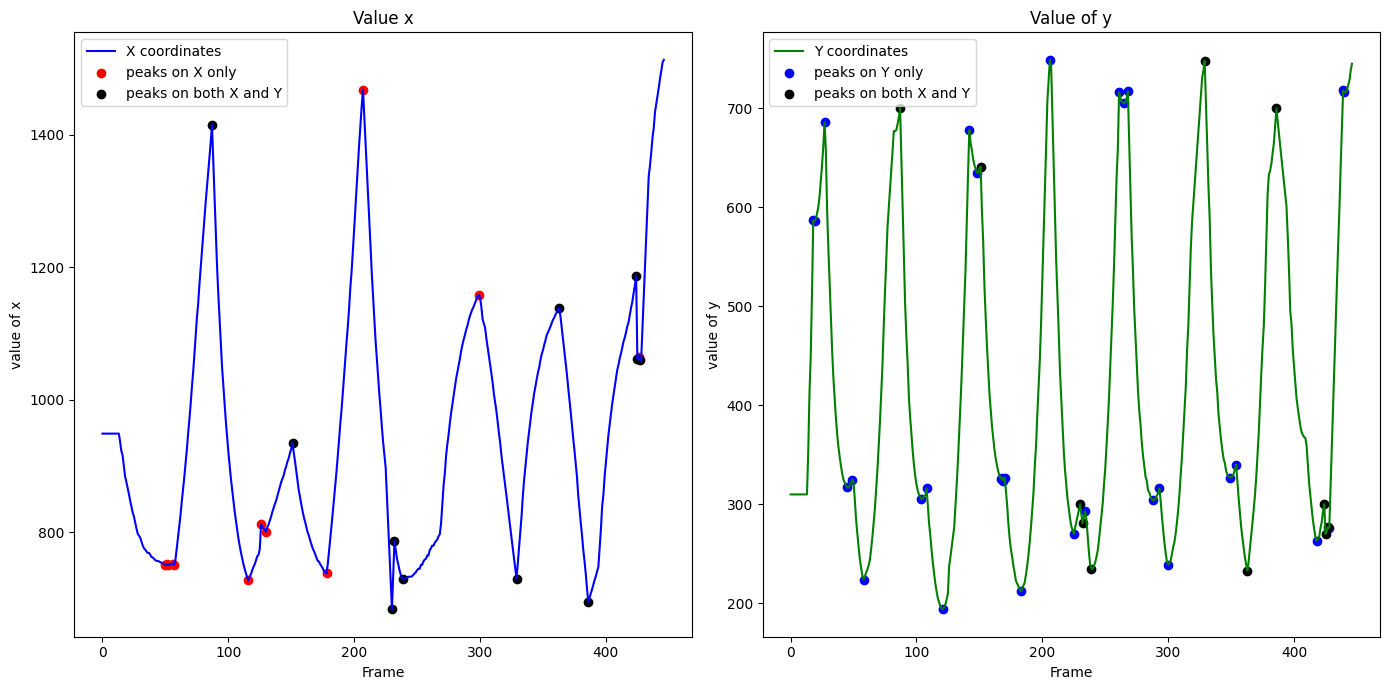

In [4]:
peaks_x = peaks_dict["peaks_x_only"]
peaks_y = peaks_dict["peaks_y_only"]
peaks_both = peaks_dict["peaks_both"]

# Plotting the derivatives in two separate 2D plots
plt.figure(figsize=(14, 7))

# Plot derivative of x
plt.subplot(1, 2, 1)
plt.plot(coordenada_x_filled, label='X coordinates', color='blue')
plt.scatter(peaks_x, coordenada_x_filled[peaks_x], color='red', label='peaks on X only')
plt.scatter(peaks_both, coordenada_x_filled[peaks_both], color='black',label="peaks on both X and Y")
plt.xlabel('Frame')
plt.ylabel('value of x')
plt.title('Value x')
plt.legend()
plt.tight_layout()


# Plot derivative of y
plt.subplot(1, 2, 2)
plt.plot(coordenada_y_filled, label='Y coordinates', color='green')
plt.scatter(peaks_y, coordenada_y_filled[peaks_y], color='blue', label='peaks on Y only')
plt.scatter(peaks_both, coordenada_y_filled[peaks_both], color='black', label="peaks on both X and Y")
plt.legend()
plt.xlabel('Frame')
plt.ylabel('value of y')
plt.title('Value of y')
plt.tight_layout()

plt.show()

# Identifying the coordinates on the court

Now that we have a method of identifying the frame in which a peak occurs, let's now use camera geometry to identify where exactly the bounce happens. 

In order to do that, let's identify the tennins court lines and then rectify it, with the rectification process done, we can transform the coordinates from the game view into the coordinates of the absolute position(retified position)

In [5]:
from visualize import *

input_video_path = "VideoInput/INPUT_play_5.mp4"
rectifyed_video_path = "VideoOutput/rec_2_output_play_5.mp4"

In [6]:
peaks_combined = np.concatenate((peaks_x, peaks_y, peaks_both))
sorted_peaks = np.sort(peaks_combined)
sorted_peaks

array([ 18,  19,  27,  45,  49,  50,  51,  52,  56,  57,  58,  87, 104,
       108, 116, 121, 126, 130, 142, 148, 151, 167, 168, 169, 170, 178,
       183, 206, 207, 225, 230, 232, 234, 239, 261, 265, 268, 288, 293,
       299, 300, 329, 349, 354, 363, 386, 418, 424, 425, 426, 427, 428,
       439, 440])

In [7]:
#show_specific_frame_and_full_path(input_video_path, 147, coordenada_x_filled, coordenada_y_filled, sorted_peaks)

In [8]:
#show_specific_frame_and_coord(input_video_path, 147,coordenada_x_filled[147] ,coordenada_y_filled[147])

# Transforming the coordinates with the rectifyied matrix

Now that we have the coordinates of the ball tracked and their moments in the video in which a possible bounce occurs, we now use the transformation Matrix (M) obtained by using the paralel lines from the court and obtain the coordinates of each bounce in the verticall (rectified) view

In [9]:
# Load the saved coordinates
with open('M.pkl', 'rb') as f:
    M = pickle.load(f)
print(M)

[[ 5.05381234e+00  2.78611570e+00 -3.84729714e+03]
 [ 2.14083279e-02 -3.95139782e+00  3.12265663e+03]
 [-4.67976838e-06  3.00589508e-03  1.00000000e+00]]


## Analysing the transformation

In [10]:
sorted_peaks

array([ 18,  19,  27,  45,  49,  50,  51,  52,  56,  57,  58,  87, 104,
       108, 116, 121, 126, 130, 142, 148, 151, 167, 168, 169, 170, 178,
       183, 206, 207, 225, 230, 232, 234, 239, 261, 265, 268, 288, 293,
       299, 300, 329, 349, 354, 363, 386, 418, 424, 425, 426, 427, 428,
       439, 440])

As seen in class, we can get an specific point by the simple matrix multiplication below:

In [11]:
x = coordenada_x_filled[169]
y = coordenada_y_filled[169]

homogeneous_coord = np.array([x, y, 1])


In [12]:
rectified_coord = M @ homogeneous_coord

In [13]:
rectified_coord

array([ 931.67841086, 1858.8239253 ,    1.97032062])

In [14]:
rectified_x = rectified_coord[0] / rectified_coord[2]
rectified_y = rectified_coord[1] / rectified_coord[2]

In [15]:
int(rectified_x)

472

In [16]:
int(rectified_y)

943

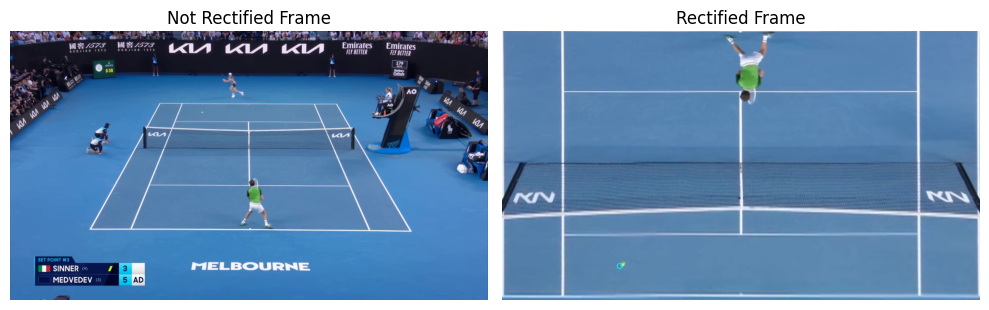

In [17]:
plot_top_down_view(input_video_path, M, 169, (int(rectified_x), int(rectified_y)))

As we can see, the matrix correctly identifies the right place of the ball, making it possible to locate the coordinate of bounce in the precise frame in which the bounce is detected.  